# Evaluation of Diagnostic Models

Welcome to the second assignment of course 1. In this assignment, we will be working with the results of the X-ray classification model we developed in the previous assignment. In order to make the data processing a bit more manageable, we will be working with a subset of our training, and validation datasets. We will also use our manually labeled test dataset of 420 X-rays.

As a reminder, our dataset contains X-rays from 14 different conditions diagnosable from an X-ray. We'll evaluate our performance on each of these classes using the classification metrics we learned in lecture.

**By the end of this assignment you will learn about:**

1. Accuracy
2. Prevalence
3. Specificity & Sensitivity
4. PPV and NPV
5. ROC curve and AUCROC (c-statistic)
6. Confidence Intervals


## Table of Contents

- [1. Packages](#1)
- [2. Overview](#2)
- [3. Metrics](#3)
    - [3.1 - True Positives, False Positives, True Negatives and False Negatives](#3-1)
        - [Exercise 1 - true positives, false positives, true negatives, and false negatives](#ex-1)
    - [3.2 - Accuracy](#3-2)
        - [Exercise 2 - get_accuracy](#ex-2)
    - [3.3 Prevalence](#3-3)
        - [Exercise 3 - get_prevalence](#ex-3)
    - [3.4 Sensitivity and Specificity](#3-4)
        - [Exercise 4 - get_sensitivity and get_specificity](#ex-4)
    - [3.5 PPV and NPV](#3-5)
        - [Exercise 5 - get_ppv and get_npv](#ex-5)
    - [3.6 ROC Curve](#3-6)
- [4. Confidence Intervals](#4)
- [5. Precision-Recall Curve](#5)
- [6. F1 Score](#6)
- [7. Calibration](#7)

<a name='1'></a>
## 1. Packages

In this assignment, we'll make use of the following packages:
- [numpy](https://docs.scipy.org/doc/numpy/) is a popular library for scientific computing
- [matplotlib](https://matplotlib.org/3.1.1/contents.html) is a plotting library compatible with numpy
- [pandas](https://pandas.pydata.org/docs/) is what we'll use to manipulate our data
- [sklearn](https://scikit-learn.org/stable/index.html) will be used to measure the performance of our model


Run the next cell to import all the necessary packages as well as custom util functions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import util
from public_tests import *
from test_utils import *

<a name='2'></a>
## 2. Overview

We'll go through our evaluation metrics in the following order.

- Metrics
  - TP, TN, FP, FN
  - Accuracy
  - Prevalence
  - Sensitivity and Specificity
  - PPV and NPV
  - AUC
- Confidence Intervals

In [3]:
train = pd.read_csv('data/train_preds.csv', index_col=0)
valid = pd.read_csv('data/valid_preds.csv', index_col=0)

train.head(3)

,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,...,Infiltration_pred,Mass_pred,Nodule_pred,Atelectasis_pred,Pneumothorax_pred,Pleural_Thickening_pred,Pneumonia_pred,Fibrosis_pred,Edema_pred,Consolidation_pred
28333,00008270_015.png,0,0,0,0,0,0,0,0,0,...,0.531233,0.077701,0.254761,0.071555,0.031860,0.125375,0.259928,0.171520,0.005386,0.079036
97164,00029855_001.png,1,0,0,0,1,0,0,0,1,...,0.530278,0.316036,0.403122,0.801598,0.793361,0.550383,0.497499,0.176103,0.359178,0.698990
4236,00001297_000.png,0,0,0,0,0,0,0,0,0,...,0.253458,0.394017,0.414019,0.426408,0.203794,0.625412,0.371834,0.693987,0.066478,0.258697


In [4]:
# get the labels
class_labels = [
     'Cardiomegaly',
     'Emphysema',
     'Effusion',
     'Hernia',
     'Infiltration',
     'Mass',
     'Nodule',
     'Atelectasis',
     'Pneumothorax',
     'Pleural_Thickening',
     'Pneumonia',
     'Fibrosis',
     'Edema',
     'Consolidation'
]

pred_labels = [l + '_pred' for l in class_labels]
pred_labels

['Cardiomegaly_pred',
 'Emphysema_pred',
 'Effusion_pred',
 'Hernia_pred',
 'Infiltration_pred',
 'Mass_pred',
 'Nodule_pred',
 'Atelectasis_pred',
 'Pneumothorax_pred',
 'Pleural_Thickening_pred',
 'Pneumonia_pred',
 'Fibrosis_pred',
 'Edema_pred',
 'Consolidation_pred']

In [6]:
# Extract the labels (y) and the predictions (pred)
y    = valid[class_labels].values
pred = valid[pred_labels].values

valid[np.concatenate([class_labels, pred_labels])].head(3)

,Cardiomegaly,Emphysema,Effusion,Hernia,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,...,Infiltration_pred,Mass_pred,Nodule_pred,Atelectasis_pred,Pneumothorax_pred,Pleural_Thickening_pred,Pneumonia_pred,Fibrosis_pred,Edema_pred,Consolidation_pred
1685,0,0,0,0,0,0,0,0,0,0,...,0.256020,0.266928,0.312440,0.460342,0.079453,0.271495,0.276861,0.398799,0.015867,0.156320
1919,0,0,0,0,1,0,1,0,0,0,...,0.382199,0.176825,0.465807,0.489424,0.084595,0.377317,0.363582,0.638024,0.025948,0.144419
2048,0,0,0,0,0,0,0,0,0,0,...,0.427727,0.115513,0.249030,0.035105,0.238761,0.167095,0.166389,0.262463,0.007758,0.125790


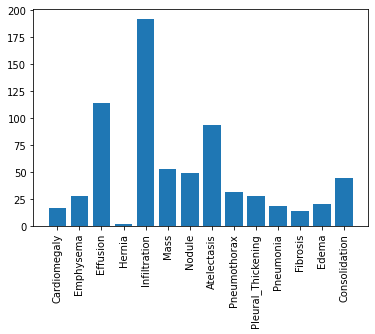

In [7]:
plt.xticks(rotation=90)
plt.bar(x = class_labels, height= y.sum(axis=0));

It seem like our dataset has an imbalanced population of samples. Specifically, our dataset has a small number of patients diagnosed with a Hernia.

<a name='3'></a>
## 3. Metrics

<a name='3-1'></a>
### 3.1 True Positives, False Positives, True Negatives and False Negatives

The most basic statistics to compute from the model predictions are the true positives, true negatives, false positives, and false negatives.

As the name suggests
- True Positive (TP): The model classifies the example as positive, and the actual label also positive.
- False Positive (FP): The model classifies the example as positive, **but** the actual label is negative.
- True Negative (TN): The model classifies the example as negative, and the actual label is also negative.
- False Negative (FN): The model classifies the example as negative, **but** the label is actually positive.

We will count the number of TP, FP, TN and FN in the given data.  All of our metrics can be built off of these four statistics.

Recall that the model outputs real numbers between 0 and 1.
* To compute binary class predictions, we need to convert these to either 0 or 1.
* We'll do this using a threshold value $th$.
* Any model outputs above $th$ are set to 1, and below $th$ are set to 0.

All of our metrics (except for AUC at the end) will depend on the choice of this threshold.

<a name='ex-1'></a>
### Exercise 1 -  true positives, false positives, true negatives and false negatives

Fill in the functions to compute the TP, FP, TN, and FN for a given threshold below.

The first one has been done for you.

In [8]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def true_positives(y, pred, th=0.5):
    """
    Count true positives.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        TP (int): true positives
    """
    TP = 0

    # get thresholded predictions
    thresholded_preds = pred >= th

    # compute TP
    TP = np.sum((y == 1) & (thresholded_preds == 1))

    return TP

def true_negatives(y, pred, th=0.5):
    """
    Count true negatives.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        TN (int): true negatives
    """
    TN = 0

    # get thresholded predictions
    thresholded_preds = pred >= th

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

    # compute TN
    TN = np.sum((y == 0) & (thresholded_preds == 0))

    ### END CODE HERE ###

    return TN

def false_positives(y, pred, th=0.5):
    """
    Count false positives.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        FP (int): false positives
    """
    FP = 0

    # get thresholded predictions
    thresholded_preds = pred >= th

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

    # compute FP
    FP = np.sum((y == 0) & (thresholded_preds == 1))

    ### END CODE HERE ###

    return FP

def false_negatives(y, pred, th=0.5):
    """
    Count false positives.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        FN (int): false negatives
    """
    FN = 0

    # get thresholded predictions
    thresholded_preds = pred >= th

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

    # compute FN
    FN = np.sum((y == 1) & (thresholded_preds == 0))

    ### END CODE HERE ###

    return FN

In [9]:
### do not modify this cell
get_tp_tn_fp_fn_test(true_positives, true_negatives, false_positives, false_negatives)

,y_test,preds_test,category
0,1,0.8,TP
1,1,0.7,TP
2,0,0.4,TN
3,0,0.3,TN
4,0,0.2,TN
5,0,0.5,FP
6,0,0.6,FP
7,0,0.7,FP
8,0,0.8,FP
9,1,0.1,FN


Your functions calcualted: 
    TP: 2
    TN: 3
    FP: 4
    FN: 5
    
 All tests passed.
 All tests passed.
 All tests passed.
 All tests passed.


In [ ]:
util.get_performance_metrics(y, pred, class_labels)